<a href="https://colab.research.google.com/github/ram130849/spatio_temporal_modelling/blob/main/Spatio_Temporal_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 15.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 17.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-5vbhpttk
  Running command git clone --filter=blob:none --quiet https://github.com/py

In [2]:
!pip install torch-geometric-temporal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 98.6 MB/s eta 0:00:00
  Created wheel for torch-geometric-temporal: filename=torch_geometric_temporal-0.54.0-py3-none-any.whl size=86726 sha256=e8c7e0e876e6bd74fc86e9cab7c9159aa83ca5ff410edf236ed88e65c531f03e
  Stored in directory: /root/.cache/pip/wheels/9e/9b/b6/e15256e053f0cb49b1084a67a709db909d418386a231f0722c
Successfully built torch-geometric-temporal
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas

In [46]:
from torch_geometric_temporal.dataset import PemsBayDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import DCRNN
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 32

In [20]:
loader = PemsBayDatasetLoader()
dataset = loader.get_dataset()
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(list(dataset)))
print(next(iter(dataset)))
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f6a4e63bac0>
Number of samples / sequences:  52082
Data(x=[325, 2, 12], edge_index=[2, 2694], edge_attr=[2694], y=[325, 2, 12])


In [6]:
# Get the length of the train dataset.
print(len(list(train_dataset)))

10416


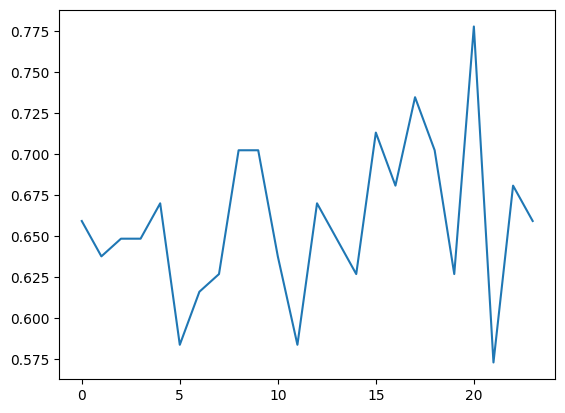

In [7]:
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0][1].item() for bucket in list(dataset)[:hours]]

plt.plot(sensor_labels)

In [40]:
# Train Dataset Loader
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array([target[:,1,:] for target in train_dataset.targets]) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE) # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array([target[:,1,:] for target in test_dataset.targets]) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [27]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

In [28]:
model = TemporalGNN(node_features=2, periods=12, batch_size=2)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.MSELoss()

model.train()

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [23]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index
    break;

In [41]:
model.train()

for epoch in range(10):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs.to(DEVICE), static_edge_index.to(DEVICE))         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0:
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.20901869347319008
0.21418751331977545
0.21527538840348523
Epoch 0 train RMSE: 0.2151
0.2028760202601552
0.20448265723884107
0.20252119457970064
Epoch 1 train RMSE: 0.2037
0.21117342878133058
0.20392858845181763
0.1954434376147886
Epoch 2 train RMSE: 0.1976
0.21099514849483966
0.2035030551534146
0.19269498096158108
Epoch 3 train RMSE: 0.1959
0.19195773951709272
0.1867327019572258
0.1940298713867863
Epoch 4 train RMSE: 0.1951
0.18107349809259177
0.19211037943139672
0.19632896127179264
Epoch 5 train RMSE: 0.1938
0.20070933582261205
0.20140948740765452
0.19425690216943622
Epoch 6 train RMSE: 0.1948
0.19056646683253348
0.1901013502245769
0.19301585162368914
Epoch 7 train RMSE: 0.1920
0.19113982265815138
0.19141172687523067
0.1915560361618797
Epoch 8 train RMSE: 0.1922
0.18032798890024423
0.19717731456272303
0.19057864315186937
Epoch 9 train RMSE: 0.1916


In [43]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs.to(DEVICE), static_edge_index.to(DEVICE))
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.1917


In [48]:
sensor = 112
timestep = 10 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

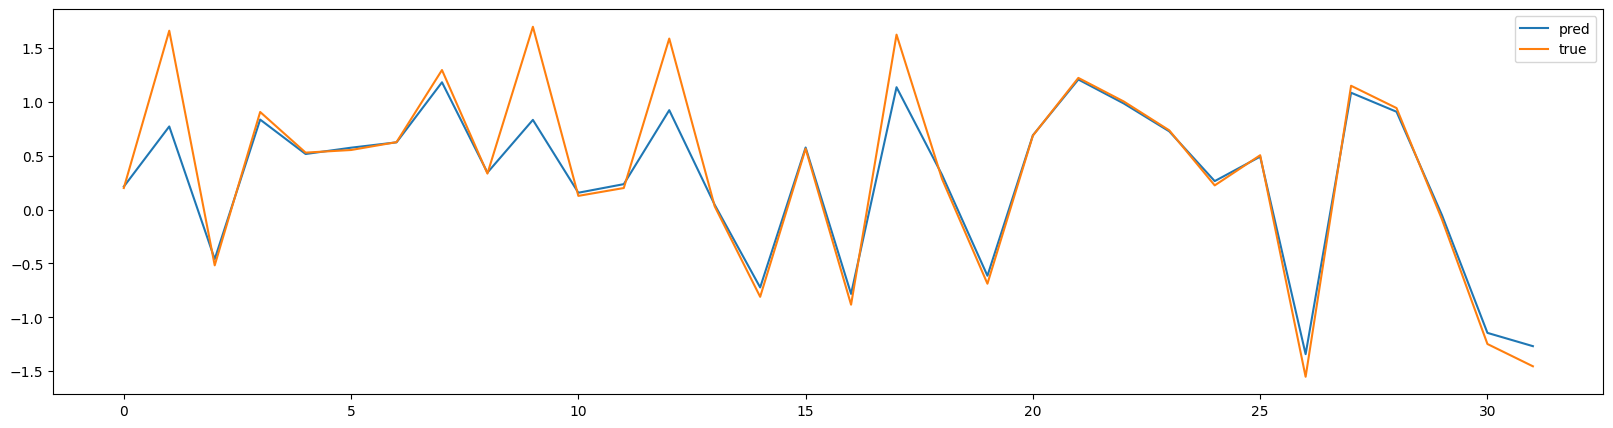

In [49]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")